# Hypergraph factorisation tutorial

In this notebook we present some of the main features of the Pytorch implementation of the Hypergraph Factorisation method, including the flexible hypergraph dataset (the implementation supports k-uniform hypergraphs for any k) and HYFA model.

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from train_gtex import *
from src.train_utils import forward
import umap
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
import wandb

sns.set_style("whitegrid")

/home/rv340/anaconda3/envs/multitissue/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
MODEL_PATH = 'data/normalised_model_default.pth'
GTEX_FILE = 'data/GTEX_data.csv'
METADATA_FILE = 'data/GTEx_Analysis_v8_Annotations_SubjectPhenotypesDS.txt'

---
## Load GTEx data

Let's load the normalised GTEx data in [AnnData](https://anndata.readthedocs.io/en/latest/) format:

In [4]:
# Load data
adata = GTEx_v8_normalised_adata(file=GTEX_FILE)
adata

/auto/homes/rv340/HYFA/train_gtex.py:69: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  adata.obs['Tissue_idx'], tissue_dict = map_to_ids(adata.obs['Tissue'].values)


AnnData object with n_obs × n_vars = 15197 × 12557
    obs: 'Participant ID', 'Tissue', 'Tissue_idx', 'Participant ID_dyn', 'Age', 'Sex'
    var: 'Symbol'
    uns: 'Tissue_dict', 'Sex_dict', 'Tissue_colors'
    obsm: 'Participant ID_feat'
    layers: 'x'

Here is a brief description of the `adata` fields:
* **obs**
    * `adata.obs['Participant ID']`: GTEx individual of every sample.
    * `adata.obs['Tissue']`: GTEx tissue of every sample.
    * `adata.obs['Tissue_idx']`: Encoded GTEx tissue. HYFA treats all fields in obs ending with `_idx` as static node types, i.e. node types with learnable node features.
    * `adata.obs['Participant ID_dyn']`: Encoded GTEx donor. HYFA treats all fields in obs ending with `_dyn` as dynamic node types, i.e. node types that are updated via message passing.

* **var**: Gene symbols

* **uns**:
    * `adata.uns['Tissue_dict']`: Dictionary mapping GTEx tissues names to identifiers.
    * `adata.uns['Sex_dict']`: Dictionary mapping sex names to identifiers.

* **obsm**
    * `adata.obsm['Participant ID_feat']`: For every field `adata.obs['*_dyn']`, `adata.obsm['*_dyn']` contains the initial node features. For example, in this case the initial node features of the individual nodes are the age and sex of the individuals.

* **layers**:
    * `adata.layers['x']` contrains the processed gene expression data.

---
## Hypergraph dataset

We split the data by donors into train, validation, and test datasets using our predefined donor splits:

In [5]:
# Split train/val/test
donors = adata.obs['Participant ID'].values
train_donors = np.loadtxt('data/splits/gtex_train.txt', delimiter=',', dtype=str)
val_donors = np.loadtxt('data/splits/gtex_val.txt', delimiter=',', dtype=str)
test_donors = np.loadtxt('data/splits/gtex_test.txt', delimiter=',', dtype=str)
train_mask = np.isin(donors, train_donors)
test_mask = np.isin(donors, test_donors)
val_mask = np.isin(donors, val_donors)

# Load datasets
train_dataset = HypergraphDataset(adata[train_mask],
                                  disjoint=True, static=False)
val_dataset = HypergraphDataset(adata[val_mask],
                                disjoint=True, static=True)
test_dataset = HypergraphDataset(adata[test_mask],
                                 static=True)

`HypergraphDataset` is a Pytorch dataset that takes care of obtaining samples by individual (i.e. argument `donor_key`). This flexible dataset has several arguments that control its behaviour:
* `adata`: AnnData object with the gene expression data
* `adata_target` (optional): Another AnnData object (same format as `adata`) with the target observations. The dataset matches individuals by `donor_key` (and discards unmatched individuals).
* `obs_source` (optional): Dictionary: AnnData `obs` keys -> selected values for the given `obs` key. The dataset filters samples from `adata` according to this dictionary. For example, the following `obs_source`
```
obs_source={'Tissue': ['Whole_Blood', 'Adipose_Visceral_Omentum'],
            'Participant ID': ['GTEX-1192X']}
```
will select the whole blood and adipose visveral omentum gene expression samples of individual `GTEX-1192X`.
* `obs_target` (optional): same as `obs_source`, but appied to the target data `adata_target`.
* `static`: Boolean value indicating whether to use static or dynamic samples. If `static=False` and `disjoint=True`, the dataset will use dynamic inputs and outputs (e.g. useful to train the model via self-supervised learning) --- the argument `sample_fn` determines the sampling behaviour. For example, `train_dataset[0].source` will yield different source tissues in different runs. If `static=True`, the dataset doesn't do any sampling.
* `disjoint`: When the dataset is not static, this argument allows to draw mutually exclusive samples via the `sample_fn` argument. By default, this samples two random sets of "collected" and "uncollected" tissues for every individual and enforces that the two sets are mutually exclusive (i.e. no overlap between source and target samples).
---

Let's now examine the contents of a dataset sample:

In [6]:
d = train_dataset[0]

The dataset returns `Data` instances with several fields, including `source`, `target`, `x_source`, `x_target`, `source_dynamic`, `target_dynamic`, `source_features`, and `target_features` among others.

In [7]:
d.source

{'Tissue': tensor([ 4, 46]), 'Participant ID': tensor([0, 0])}

The `source` field contains the `obs` (mapped) information of the source donors (see section above with fields of AnnData object), e.g. IDs of both dynamic and static node types. You can map the static nodes (e.g. tissues) back to the original names through the dictionary that was used to map the static node names to identifiers. For example, for the GTEx tissues, we stored this dictionary in `adata.uns['Tissue_dict']`. Similarly, `d.target` contains the information for the target samples:

In [8]:
d.target

{'Tissue': tensor([ 0,  1,  5, 11, 19, 27, 32, 33, 39, 47]),
 'Participant ID': tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0])}

The unmapped information of the dynamic nodes (e.g. `Participant ID`) is available through `d.source_dynamic` (source samples) and `d.target_dynamic` (target samples):

In [9]:
d.source_dynamic

{'Participant ID': 1670     GTEX-1117F
 14261    GTEX-1117F
 Name: Participant ID_dyn, dtype: object}

In [10]:
d.target_dynamic

{'Participant ID': 0        GTEX-1117F
 581      GTEX-1117F
 1883     GTEX-1117F
 3321     GTEX-1117F
 4648     GTEX-1117F
 7652     GTEX-1117F
 9206     GTEX-1117F
 9350     GTEX-1117F
 11518    GTEX-1117F
 14390    GTEX-1117F
 Name: Participant ID_dyn, dtype: object}

The initial node features of the source and target nodes are available via `d.source_features` and `d.target_features`, respectively:

In [11]:
d.target_features

{'Participant ID': tensor([[0.6000, 1.0000],
         [0.6000, 1.0000],
         [0.6000, 1.0000],
         [0.6000, 1.0000],
         [0.6000, 1.0000],
         [0.6000, 1.0000],
         [0.6000, 1.0000],
         [0.6000, 1.0000],
         [0.6000, 1.0000],
         [0.6000, 1.0000]], dtype=torch.float64)}

Note that we used the arguments `disjoint=True` and `static=False` for the train dataset, so the dataset is dynamically drawing samples that are mutually exclusive, i.e. non-overlapping sets of tissues. The corresponding gene expression information of the source and target samples is stored in `d.x_source` and `d.x_target`, correspondingly:

In [12]:
d.x_source

tensor([[ 0.5406,  0.1529,  0.0469,  ..., -0.6967, -0.5406,  0.5271],
        [ 1.1228, -0.4806, -0.1940,  ..., -0.0193, -0.2137, -0.9272]])

In [13]:
d.x_target

tensor([[ 0.7381, -0.1775, -2.5653,  ...,  2.5653,  2.5653, -2.2045],
        [ 1.3853, -0.9533,  2.3030,  ...,  0.0640,  0.3369, -0.6711],
        [ 0.7879, -1.0493,  0.7533,  ..., -0.8055,  2.7047, -1.2206],
        ...,
        [ 0.2857,  0.2673,  0.8954,  ...,  0.4766,  0.8186, -1.3120],
        [ 1.8409, -0.5266,  0.7719,  ...,  2.0289, -1.2161,  0.1213],
        [-0.7779,  1.5863, -0.6856,  ..., -1.9084,  0.5366,  1.8092]])

We can map the information of a `Data` object to a Pytorch device via the `d.to(device)` method.

In [14]:
d = d.to('cuda:0')
d.source

{'Tissue': tensor([ 4, 46], device='cuda:0'),
 'Participant ID': tensor([0, 0], device='cuda:0')}

In [15]:
d.x_source

tensor([[ 0.5406,  0.1529,  0.0469,  ..., -0.6967, -0.5406,  0.5271],
        [ 1.1228, -0.4806, -0.1940,  ..., -0.0193, -0.2137, -0.9272]],
       device='cuda:0')

In [16]:
d.x_target

tensor([[ 0.7381, -0.1775, -2.5653,  ...,  2.5653,  2.5653, -2.2045],
        [ 1.3853, -0.9533,  2.3030,  ...,  0.0640,  0.3369, -0.6711],
        [ 0.7879, -1.0493,  0.7533,  ..., -0.8055,  2.7047, -1.2206],
        ...,
        [ 0.2857,  0.2673,  0.8954,  ...,  0.4766,  0.8186, -1.3120],
        [ 1.8409, -0.5266,  0.7719,  ...,  2.0289, -1.2161,  0.1213],
        [-0.7779,  1.5863, -0.6856,  ..., -1.9084,  0.5366,  1.8092]],
       device='cuda:0')

Now that we've covered the basics of `HypergraphDataset`, let's see how to instantiate HYFA.

---
## HYFA model

We start by initialising weights and biases and loading the YAML config file with HYFA's hyperparameters for the normalised GTEx data.

In [17]:
# Initialise wandb
wandb.init(project='multitissue_imputation', config='configs/default.yaml', mode='disabled')
config = wandb.config
print(config)

{'gpu': 0, 'sweep': False, 'lr': 0.00045568167228053424, 'batch_size': 63, 'epochs': 200, 'patience': 30, 'dropout': 0.17385777664292695, 'bn': True, 'use_demographic_information': True, 'update_edge_attr': False, 'n_graph_layers': 2, 'n_hidden_layers': 1, 'n_hidden_layers_pred': 2, 'n_hidden_layers_prior_var': 0, 'meta_G': 50, 'd_patient': 71, 'd_gene': 48, 'd_edge_attr': 98, 'd_tissue': 120, 'd_edge': 28, 'n_heads': 28, 'beta': 0, 'n_top_genes': None, 'attention_strategy': 'patient', 'metagenes_encoder': 'plain', 'loss_type': 'normal', 'layer': 'gat', 'activation': 'swish', 'norm': 'batch'}


Most hyperparameters are self-explanatory. Here is a brief description of the most important:
* `n_graph_layers`: Number of message passing layers.
* `meta_G`: Number of metagenes. Each metagene captures one mode of interaction (e.g. similar to channels in a convolutional neural network).
* `d_patient`: Dimensionality of the donor node features.
* `d_gene`: Dimensionality of the metagene node features.
* `d_tissue`: Dimensionality of the tissue node features.
* `d_edge_attr`: Dimensionality of the hyperedge attributes.
* `d_edge`: Dimensionality of the message vectors.
* `n_heads`: Number of heads in the message aggregation mechanism.
* `loss_type`: Likelihood function name.

We now create Pytorch data loaders for the train, validation, and test sets.

In [18]:
# Load data loaders
train_loader = DataLoader(train_dataset,
                          batch_size=config.batch_size,
                          collate_fn=Data.from_datalist,
                          shuffle=True)
val_loader = DataLoader(val_dataset,
                        batch_size=config.batch_size,
                        collate_fn=Data.from_datalist,
                        shuffle=False)
test_loader = DataLoader(test_dataset,
                         batch_size=config.batch_size,
                         collate_fn=Data.from_datalist,
                         shuffle=False)

The argument `collate_fn` specifies how to create batches from multiple data objects. The function `Data.from_datalist` takes care of merging several `Data` objects output by the dataset into a single one (i.e. it reindexes the IDs of dynamic nodes).

Let's now instantiate the model:

In [19]:
# Use certain GPU
device = torch.device("cuda:{}".format(config.gpu) if torch.cuda.is_available() else "cpu")

# Select dynamic/static node types
config.update({'static_node_types': {
    'Tissue': (len(adata.obs['Tissue_idx'].unique()), config.d_tissue),
    'metagenes': (config.meta_G, config.d_gene)
}}, allow_val_change=True)
config.update({'dynamic_node_types': {
    'Participant ID': (len(adata.obs['Participant ID'].unique()), config.d_patient)
}}, allow_val_change=True)

# Model
config.G = adata.shape[-1]
model = HypergraphNeuralNet(config).to(device)

The attributes `'static_node_types'` and `'dynamic_node_types'` of the `config` object specify the properties of the static and dynamic node types of the hypergraph. The model relies on these two fields to determine the number of node types, their dimensions, and whether they should be updated during message passing (static vs dynamic node types). For every node type (i.e. key in dictionary), we specified the number of nodes as well as their dimensions (`n_nodes`, `node_dim`). The `metagenes` field is special (the model will *not* look for this key in `d.source`) and expected by the model - it determines the number and dimension of the metagenes.

We have now instantiated HYFA. To train the model, we provide a `train` function that trains the model and takes in the config object, the HYFA model, the train and validation loaders, as well as other optional keyword arguments. See the `train_gtex.py` script for an example.

---
## Inferring uncollected gene expression

We now load the parameters of a trained HYFA model and generate predictions for uncollected tissues. This step assumes that the architecture and hyperparameters are the same used for training. 

In [20]:
# Load model parameters
model.load_state_dict(torch.load(MODEL_PATH))
model.eval();

Let's infer the expression of uncollected tissues for individuals in the validation set, using data from accessible tissues. First, we'll select validation individuals with gene expression collected in all GTEx accessible tissues (whole blood, skin sun exposed, skin not sun exposed, and adipose subcutaneous), as well as a target tissue, say esophagus mucosa, which we assume to be uncollected.

In [21]:
split_mask = val_mask
source_tissues = ['Whole_Blood', 'Skin_Sun_Epsd', 'Skin_Not_Sun_Epsd', 'Adipose_Subcutaneous']
target_tissues = ['Esophagus_Mucosa']

valid_donors = []
donors = adata[split_mask].obs['Participant ID'].unique()
for donor in donors:
    donor_mask = adata[split_mask].obs['Participant ID'] == donor
    all_tissues_collected = all([t in adata[split_mask].obs[donor_mask]['Tissue'].values for t in source_tissues + target_tissues])
    if all_tissues_collected:
        valid_donors.append(donor)
len(valid_donors)

42

We now instantiate an auxiliary dataset and data loader for the selected donors in `valid_donors`. We can use `obs_source` and `obs_target` to select the donors and tissues from above. For now, we will use a single reference tissue (whole blood).

In [22]:
source_tissues_1 = ['Whole_Blood']
aux_val_dataset = HypergraphDataset(adata[split_mask],
                                    obs_source={'Tissue': source_tissues_1, 'Participant ID': valid_donors},
                                    obs_target={'Tissue': target_tissues, 'Participant ID': valid_donors},
                                    static=True, 
                                    verbose=True)
aux_val_loader = DataLoader(aux_val_dataset,
                            batch_size=len(aux_val_dataset),
                            collate_fn=Data.from_datalist,
                            shuffle=False)

Selected 42 source and 42 target samples of 42 unique donors


We feed the data to HYFA to get the inferred esophagus mucosa gene expession for the selected validation individuals. To do so, we use the `forward` method which executes HYFA's workflow (infer low-dimensional metagene features for source tissues, perform message passing in the 3-uniform hypergraph, and hyperedge-level prediction to recover the uncollected gene expression). We set the argument `preprocess_fn` to `None` to indicate that the source data doesn't need to be processed. In the case of unnormalised gene expression, we can use an appropriate function (e.g. `torch.log1p`).

In [23]:
d = next(iter(aux_val_loader))
with torch.no_grad():
    out, node_features = forward(d, model, device, preprocess_fn=None)
    x_pred = out['px_rate'].cpu().numpy()

By default, if the model was trained using a normal likelihood, the attribute `'px_rate'` contains the prediction means. We'll use this as the inferred gene expression. We can now assess prediction performance by comparing the predictions with the ground truth, stored in `d.x_target`:

(0.39947408, 0.16053617)

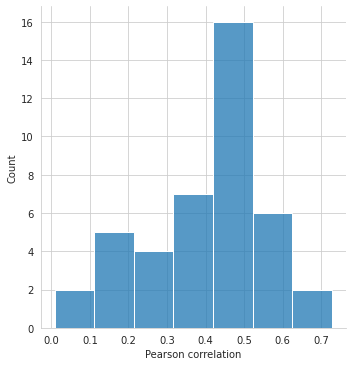

In [24]:
scores = pearson_correlation_score(d.x_target.cpu().numpy(), x_pred, sample_corr=True)
sns.displot(scores)
plt.xlabel('Pearson correlation')
np.mean(scores), np.std(scores)

Not bad! These are per-sample scores. Let's see if we can improve the predictions by taking multiple tissues as reference for the same validation individuals.

In [25]:
source_tissues_2 = ['Whole_Blood', 'Skin_Sun_Epsd', 'Skin_Not_Sun_Epsd', 'Adipose_Subcutaneous']
aux_val_dataset_2 = HypergraphDataset(adata[split_mask],
                                    obs_source={'Tissue': source_tissues_2, 'Participant ID': valid_donors},
                                    obs_target={'Tissue': target_tissues, 'Participant ID': valid_donors},
                                    static=True, 
                                    verbose=True)
aux_val_loader_2 = DataLoader(aux_val_dataset_2,
                            batch_size=len(aux_val_dataset_2),
                            collate_fn=Data.from_datalist,
                            shuffle=False)

Selected 168 source and 42 target samples of 42 unique donors


Let's feed the data (accessible tissues) through the model:

In [26]:
d = next(iter(aux_val_loader_2))
with torch.no_grad():
    out, node_features = forward(d, model, device, preprocess_fn=None)
    x_pred = out['px_rate'].cpu().numpy()

The average prediction performance are now higher (though the predictions seem worse for a couple of individuals):

(0.4354319, 0.18939544)

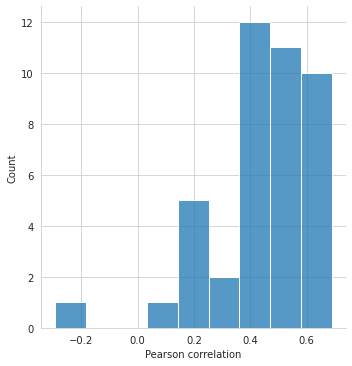

In [27]:
scores = pearson_correlation_score(d.x_target.cpu().numpy(), x_pred, sample_corr=True)
sns.displot(scores)
plt.xlabel('Pearson correlation')
np.mean(scores), np.std(scores)

Well done! As an exercise, you may try to impute the gene expression of the target tissue using all collected tissues of the individual. Think about how you could set up the auxiliary dataset to select the appropriate samples (note that different individuals may have different collected tissues).

---
## Plotting the HYFA's learnt tissue embeddings

In this section, we explore HYFA's learnt tissue embeddings (i.e. learnable node features in the hypergraph). We gather the learnt tissue features as follows:

In [28]:
params = model.params['Tissue'].cpu().detach().numpy()

We will now apply UMAP to project these parameters into a 2-dimensional space:

In [29]:
tissue_params_2d = umap.UMAP().fit_transform(params)

We finally plot the low-dimensional tissue embeddings:

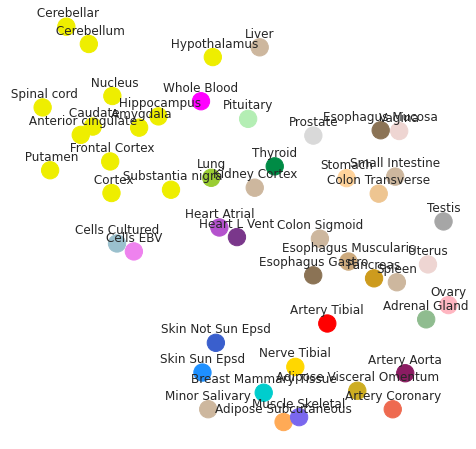

In [30]:
plt.figure(figsize=(8, 8))
ax = plt.gca()
x1, x2 = tissue_params_2d.T
ax.scatter(x1, x2,
           c=adata.uns['Tissue_colors'],
           s=300)

for t, i in adata.uns['Tissue_dict'].items():
    x_coord = x1[i]
    y_coord = x2[i]
    txt = t.replace('_', ' ').replace('Brain', '')
        
    ax.annotate(txt, (x_coord, y_coord),
                textcoords="offset points",  # how to position the text
                xytext=(0, 10),  # distance from text to points (x,y)
                fontsize=12,
                ha='center')

plt.axis('off');

We observe strong cluster of biologically related tissues (e.g. see brain tissues in yellow). Cool!